In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from datetime import time, datetime
%matplotlib inline
import statsmodels.api as sm
import warnings
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from collections import defaultdict
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("Beatrice_wind_data.csv")

In [3]:
df

,Unnamed: 0,time,u100,v100,fsr,Windspeed,Scaled_Windspeed_(at_90m),Wind_Direction,Power_of_SWT-7.0-154,Turn_off,Power
0,0,01-01-1980 00:00,1.808975,-10.229706,0.000261,10.388420,10.150733,100.028260,378.95800,1,378.95800
1,1,01-01-1980 01:00,1.916092,-10.346832,0.000242,10.522754,10.281994,100.491540,390.87520,1,390.87520
2,2,01-01-1980 02:00,1.940201,-10.212601,0.000230,10.395267,10.157425,100.756920,379.56732,1,379.56732
3,3,01-01-1980 03:00,2.296951,-10.099304,0.000224,10.357217,10.120245,102.813194,376.18005,1,376.18005
4,4,01-01-1980 04:00,2.725143,-10.351501,0.000238,10.704205,10.459293,104.749070,406.82446,1,406.82446
...,...,...,...,...,...,...,...,...,...,...,...
350635,350635,31-12-2019 19:00,5.339706,5.910355,0.000109,7.965221,7.782983,227.903780,176.63489,1,176.63489
350636,350636,31-12-2019 20:00,5.571014,5.264069,0.000092,7.664634,7.489274,223.377300,156.59825,1,156.59825
350637,350637,31-12-2019 21:00,5.881805,5.061096,0.000089,7.759531,7.582000,220.710890,162.77127,1,162.77127
350638,350638,31-12-2019 22:00,5.934189,4.434921,0.000077,7.408314,7.238819,216.772630,140.61679,1,140.61679


In [4]:
df.drop(columns=['Turn_off'],axis=1,inplace=True)

In [5]:
df.drop(columns=['Power_of_SWT-7.0-154'],axis=1,inplace=True)

In [6]:
df

,Unnamed: 0,time,u100,v100,fsr,Windspeed,Scaled_Windspeed_(at_90m),Wind_Direction,Power
0,0,01-01-1980 00:00,1.808975,-10.229706,0.000261,10.388420,10.150733,100.028260,378.95800
1,1,01-01-1980 01:00,1.916092,-10.346832,0.000242,10.522754,10.281994,100.491540,390.87520
2,2,01-01-1980 02:00,1.940201,-10.212601,0.000230,10.395267,10.157425,100.756920,379.56732
3,3,01-01-1980 03:00,2.296951,-10.099304,0.000224,10.357217,10.120245,102.813194,376.18005
4,4,01-01-1980 04:00,2.725143,-10.351501,0.000238,10.704205,10.459293,104.749070,406.82446
...,...,...,...,...,...,...,...,...,...
350635,350635,31-12-2019 19:00,5.339706,5.910355,0.000109,7.965221,7.782983,227.903780,176.63489
350636,350636,31-12-2019 20:00,5.571014,5.264069,0.000092,7.664634,7.489274,223.377300,156.59825
350637,350637,31-12-2019 21:00,5.881805,5.061096,0.000089,7.759531,7.582000,220.710890,162.77127
350638,350638,31-12-2019 22:00,5.934189,4.434921,0.000077,7.408314,7.238819,216.772630,140.61679


In [7]:
df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [8]:
def check_nans(df):
  x = df.isnull().sum()
  print(x)

In [9]:
# we should check for any unrealistic data for Power,unwanted data should be omitted
# wec
check_nans(df)

time                         0
u100                         0
v100                         0
fsr                          0
Windspeed                    0
Scaled_Windspeed_(at_90m)    0
Wind_Direction               0
Power                        0
dtype: int64


In [10]:
df

,time,u100,v100,fsr,Windspeed,Scaled_Windspeed_(at_90m),Wind_Direction,Power
0,01-01-1980 00:00,1.808975,-10.229706,0.000261,10.388420,10.150733,100.028260,378.95800
1,01-01-1980 01:00,1.916092,-10.346832,0.000242,10.522754,10.281994,100.491540,390.87520
2,01-01-1980 02:00,1.940201,-10.212601,0.000230,10.395267,10.157425,100.756920,379.56732
3,01-01-1980 03:00,2.296951,-10.099304,0.000224,10.357217,10.120245,102.813194,376.18005
4,01-01-1980 04:00,2.725143,-10.351501,0.000238,10.704205,10.459293,104.749070,406.82446
...,...,...,...,...,...,...,...,...
350635,31-12-2019 19:00,5.339706,5.910355,0.000109,7.965221,7.782983,227.903780,176.63489
350636,31-12-2019 20:00,5.571014,5.264069,0.000092,7.664634,7.489274,223.377300,156.59825
350637,31-12-2019 21:00,5.881805,5.061096,0.000089,7.759531,7.582000,220.710890,162.77127
350638,31-12-2019 22:00,5.934189,4.434921,0.000077,7.408314,7.238819,216.772630,140.61679


In [11]:
df.describe()

,u100,v100,fsr,Windspeed,Scaled_Windspeed_(at_90m),Wind_Direction,Power
count,350640.000000,350640.000000,350640.000000,350640.000000,350640.000000,350640.000000,350640.000000
mean,1.862023,2.024616,0.000274,9.553600,9.335005,202.561440,299.145351
std,6.959710,7.441705,0.000392,4.484554,4.381924,88.722614,221.279949
min,-27.752228,-29.174866,0.000025,0.019537,0.019090,0.002441,0.000000
25%,-3.106934,-3.233860,0.000049,6.216734,6.074501,134.165175,78.491346
50%,1.939735,2.557854,0.000123,9.343687,9.129908,211.034530,285.495330
75%,6.913158,7.519260,0.000320,12.537567,12.250706,277.424225,542.804882
max,31.001312,28.337387,0.006824,35.949060,35.125920,359.999820,588.000000


In [12]:
df.max()

time                         31-12-2019 23:00
u100                                31.001312
v100                                28.337387
fsr                                  0.006824
Windspeed                            35.94906
Scaled_Windspeed_(at_90m)            35.12592
Wind_Direction                      359.99982
Power                                   588.0
dtype: object

In [13]:
  df1 = df.unstack()

In [14]:
df1

time   0         01-01-1980 00:00
       1         01-01-1980 01:00
       2         01-01-1980 02:00
       3         01-01-1980 03:00
       4         01-01-1980 04:00
                       ...       
Power  350635           176.63489
       350636           156.59825
       350637           162.77127
       350638           140.61679
       350639           175.21983
Length: 2805120, dtype: object

In [15]:
df1.head()

time  0    01-01-1980 00:00
      1    01-01-1980 01:00
      2    01-01-1980 02:00
      3    01-01-1980 03:00
      4    01-01-1980 04:00
dtype: object

In [16]:
#u100= the wind velocity at 100 m height horizontal west to east
#

In [17]:
import seaborn as sns


In [18]:
df1=df.loc[:,['time','Wind_Direction']]

In [19]:
df1

,time,Wind_Direction
0,01-01-1980 00:00,100.028260
1,01-01-1980 01:00,100.491540
2,01-01-1980 02:00,100.756920
3,01-01-1980 03:00,102.813194
4,01-01-1980 04:00,104.749070
...,...,...
350635,31-12-2019 19:00,227.903780
350636,31-12-2019 20:00,223.377300
350637,31-12-2019 21:00,220.710890
350638,31-12-2019 22:00,216.772630


In [20]:
"""plt.xlabel('time')
plt.ylabel('Wind_Direction')
plt.scatter(df1.time,df1.Wind_Direction,color='blue',marker='*')"""

"plt.xlabel('time')\nplt.ylabel('Wind_Direction')\nplt.scatter(df1.time,df1.Wind_Direction,color='blue',marker='*')"

In [21]:
#df.plot.scatter(x='time',y='Power')

In [22]:
df.loc[:,'time']

0         01-01-1980 00:00
1         01-01-1980 01:00
2         01-01-1980 02:00
3         01-01-1980 03:00
4         01-01-1980 04:00
                ...       
350635    31-12-2019 19:00
350636    31-12-2019 20:00
350637    31-12-2019 21:00
350638    31-12-2019 22:00
350639    31-12-2019 23:00
Name: time, Length: 350640, dtype: object

In [23]:
#sns.pairplot(df)

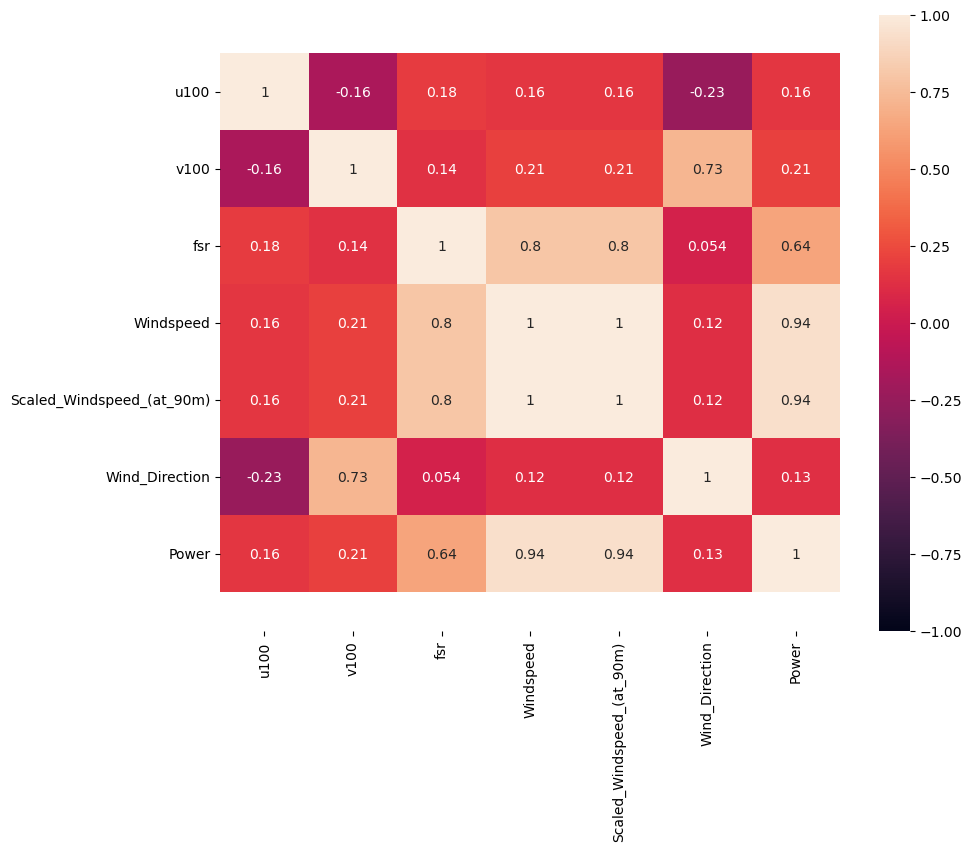

,u100,v100,fsr,Windspeed,Scaled_Windspeed_(at_90m),Wind_Direction,Power
u100,1.000000,-0.155406,0.181921,0.162451,0.162450,-0.234869,0.162682
v100,-0.155406,1.000000,0.138076,0.205048,0.205048,0.726529,0.208469
fsr,0.181921,0.138076,1.000000,0.800243,0.800240,0.053928,0.638085
Windspeed,0.162451,0.205048,0.800243,1.000000,1.000000,0.123430,0.935780
Scaled_Windspeed_(at_90m),0.162450,0.205048,0.800240,1.000000,1.000000,0.123430,0.935781
Wind_Direction,-0.234869,0.726529,0.053928,0.123430,0.123430,1.000000,0.127955
Power,0.162682,0.208469,0.638085,0.935780,0.935781,0.127955,1.000000


In [24]:
#correlation between the values
corr = df.corr()
plt.figure(figsize=(10, 8))

ax = sns.heatmap(corr, vmin = -1, vmax = 1, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
corr

In [25]:
df

,time,u100,v100,fsr,Windspeed,Scaled_Windspeed_(at_90m),Wind_Direction,Power
0,01-01-1980 00:00,1.808975,-10.229706,0.000261,10.388420,10.150733,100.028260,378.95800
1,01-01-1980 01:00,1.916092,-10.346832,0.000242,10.522754,10.281994,100.491540,390.87520
2,01-01-1980 02:00,1.940201,-10.212601,0.000230,10.395267,10.157425,100.756920,379.56732
3,01-01-1980 03:00,2.296951,-10.099304,0.000224,10.357217,10.120245,102.813194,376.18005
4,01-01-1980 04:00,2.725143,-10.351501,0.000238,10.704205,10.459293,104.749070,406.82446
...,...,...,...,...,...,...,...,...
350635,31-12-2019 19:00,5.339706,5.910355,0.000109,7.965221,7.782983,227.903780,176.63489
350636,31-12-2019 20:00,5.571014,5.264069,0.000092,7.664634,7.489274,223.377300,156.59825
350637,31-12-2019 21:00,5.881805,5.061096,0.000089,7.759531,7.582000,220.710890,162.77127
350638,31-12-2019 22:00,5.934189,4.434921,0.000077,7.408314,7.238819,216.772630,140.61679


In [26]:
cols=list(df)[1:8]

In [27]:
cols

['u100',
 'v100',
 'fsr',
 'Windspeed',
 'Scaled_Windspeed_(at_90m)',
 'Wind_Direction',
 'Power']

In [28]:
df=df[cols].astype(float)

In [29]:
df

,u100,v100,fsr,Windspeed,Scaled_Windspeed_(at_90m),Wind_Direction,Power
0,1.808975,-10.229706,0.000261,10.388420,10.150733,100.028260,378.95800
1,1.916092,-10.346832,0.000242,10.522754,10.281994,100.491540,390.87520
2,1.940201,-10.212601,0.000230,10.395267,10.157425,100.756920,379.56732
3,2.296951,-10.099304,0.000224,10.357217,10.120245,102.813194,376.18005
4,2.725143,-10.351501,0.000238,10.704205,10.459293,104.749070,406.82446
...,...,...,...,...,...,...,...
350635,5.339706,5.910355,0.000109,7.965221,7.782983,227.903780,176.63489
350636,5.571014,5.264069,0.000092,7.664634,7.489274,223.377300,156.59825
350637,5.881805,5.061096,0.000089,7.759531,7.582000,220.710890,162.77127
350638,5.934189,4.434921,0.000077,7.408314,7.238819,216.772630,140.61679


In [30]:
# normalise the datas except date 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalised_column = ['u100','v100','fsr','Windspeed','Scaled_Windspeed_(at_90m)','Wind_Direction','Power']
df[normalised_column] = scaler.fit_transform(df[normalised_column])

In [31]:
print(df[normalised_column])

            u100      v100       fsr  Windspeed  Scaled_Windspeed_(at_90m)  \
0       0.503139  0.329411  0.034656   0.288589                   0.288595   
1       0.504962  0.327374  0.031856   0.292328                   0.292334   
2       0.505373  0.329708  0.030083   0.288780                   0.288785   
3       0.511445  0.331678  0.029148   0.287721                   0.287726   
4       0.518733  0.327293  0.031296   0.297379                   0.297384   
...          ...       ...       ...        ...                        ...   
350635  0.563233  0.610048  0.012311   0.221146                   0.221150   
350636  0.567170  0.598810  0.009797   0.212780                   0.212784   
350637  0.572460  0.595281  0.009326   0.215422                   0.215426   
350638  0.573351  0.584394  0.007649   0.205646                   0.205650   
350639  0.574201  0.598144  0.009679   0.220574                   0.220579   

        Wind_Direction     Power  
0             0.277852  0.64

In [32]:
df[normalised_column].Power

0         0.644486
1         0.664754
2         0.645523
3         0.639762
4         0.691878
            ...   
350635    0.300399
350636    0.266324
350637    0.276822
350638    0.239144
350639    0.297993
Name: Power, Length: 350640, dtype: float64

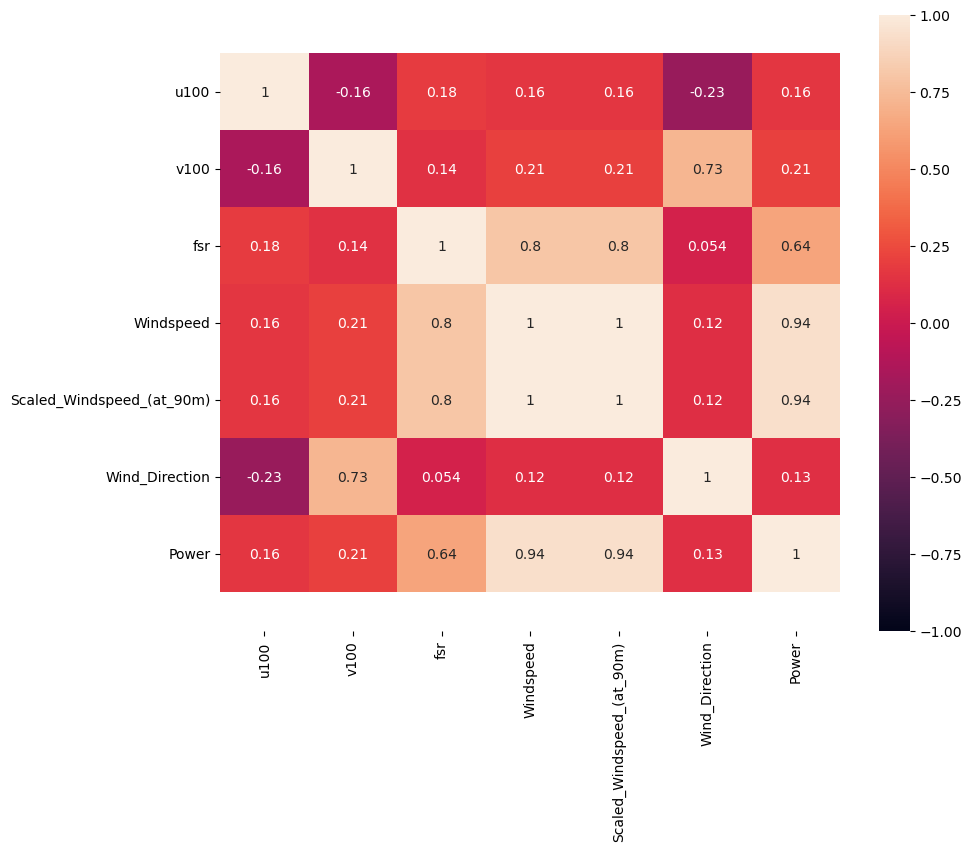

,u100,v100,fsr,Windspeed,Scaled_Windspeed_(at_90m),Wind_Direction,Power
u100,1.000000,-0.155406,0.181921,0.162451,0.162450,-0.234869,0.162682
v100,-0.155406,1.000000,0.138076,0.205048,0.205048,0.726529,0.208469
fsr,0.181921,0.138076,1.000000,0.800243,0.800240,0.053928,0.638085
Windspeed,0.162451,0.205048,0.800243,1.000000,1.000000,0.123430,0.935780
Scaled_Windspeed_(at_90m),0.162450,0.205048,0.800240,1.000000,1.000000,0.123430,0.935781
Wind_Direction,-0.234869,0.726529,0.053928,0.123430,0.123430,1.000000,0.127955
Power,0.162682,0.208469,0.638085,0.935780,0.935781,0.127955,1.000000


In [33]:
corr = df[normalised_column].corr()
plt.figure(figsize=(10, 8))

ax = sns.heatmap(corr, vmin = -1, vmax = 1, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
corr

In [34]:

#df[normalised_column].plot('Power')

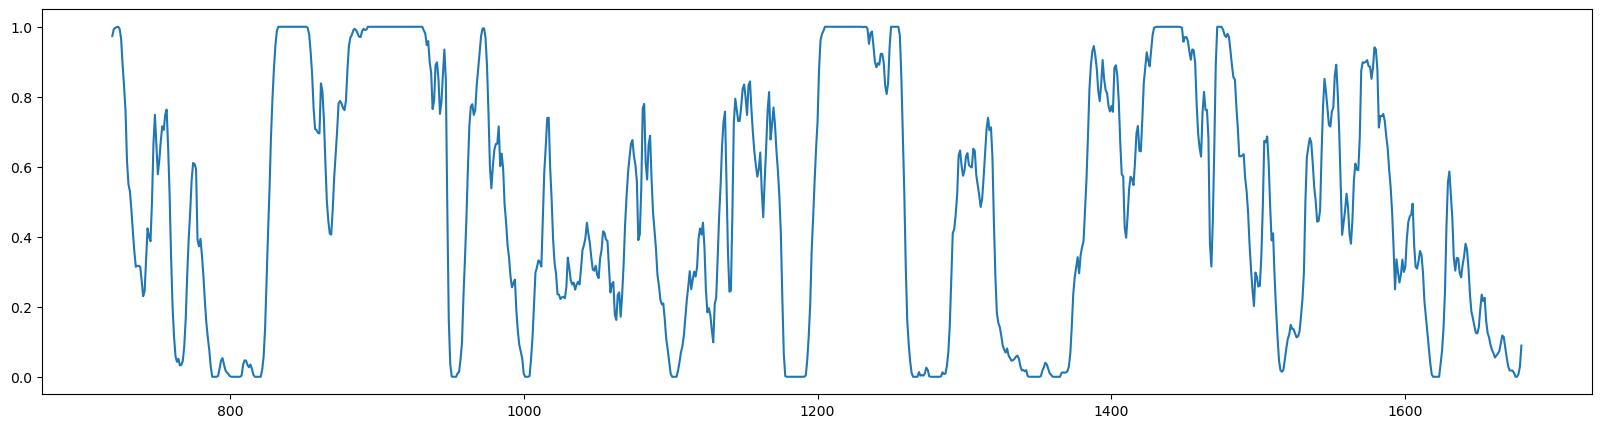

In [35]:
plt.figure(figsize=(20, 5))
plt.plot(df[normalised_column].Power[24*30:24*70])
plt.show()

In [36]:
df[normalised_column].rename(columns={'Scaled_Windspeed_(at_90m)':'Scaled_Windspeed'}, inplace=True)

In [37]:
df[normalised_column]

,u100,v100,fsr,Windspeed,Scaled_Windspeed_(at_90m),Wind_Direction,Power
0,0.503139,0.329411,0.034656,0.288589,0.288595,0.277852,0.644486
1,0.504962,0.327374,0.031856,0.292328,0.292334,0.279138,0.664754
2,0.505373,0.329708,0.030083,0.288780,0.288785,0.279876,0.645523
3,0.511445,0.331678,0.029148,0.287721,0.287726,0.285588,0.639762
4,0.518733,0.327293,0.031296,0.297379,0.297384,0.290965,0.691878
...,...,...,...,...,...,...,...
350635,0.563233,0.610048,0.012311,0.221146,0.221150,0.633064,0.300399
350636,0.567170,0.598810,0.009797,0.212780,0.212784,0.620490,0.266324
350637,0.572460,0.595281,0.009326,0.215422,0.215426,0.613083,0.276822
350638,0.573351,0.584394,0.007649,0.205646,0.205650,0.602144,0.239144


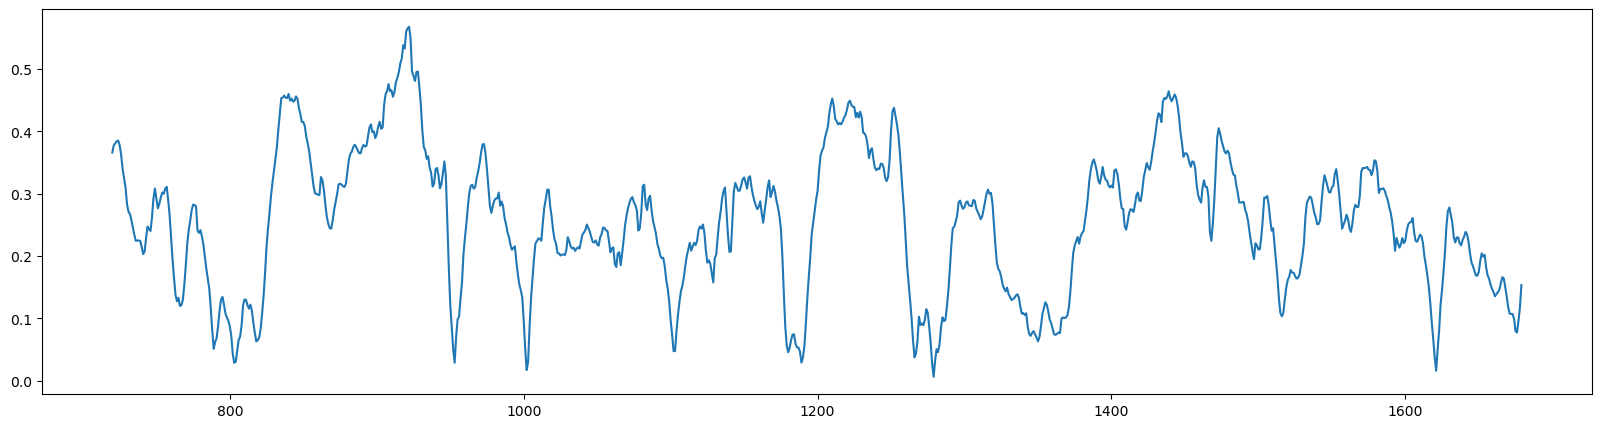

In [38]:
plt.figure(figsize=(20, 5))
plt.plot(df[normalised_column].Windspeed[24*30:24*70])
plt.show()

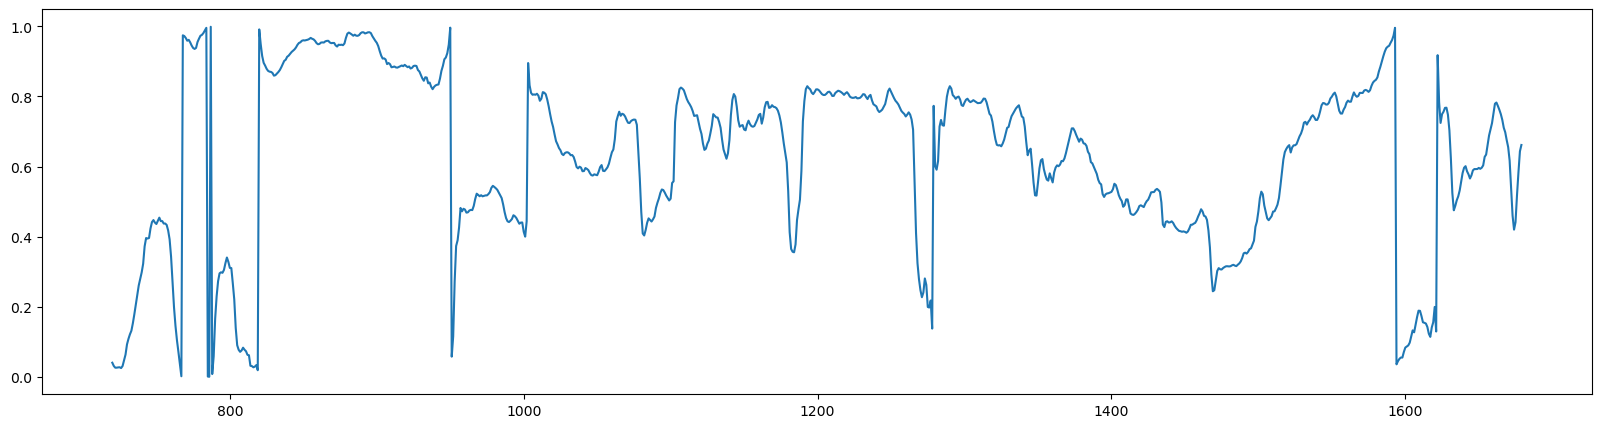

In [39]:
plt.figure(figsize=(20, 5))
plt.plot(df[normalised_column].Wind_Direction[24*30:24*70])
plt.show()

In [40]:
df2=df[normalised_column].rename(columns={'Scaled_Windspeed_(at_90m)':'Scaled_Windspeed'})

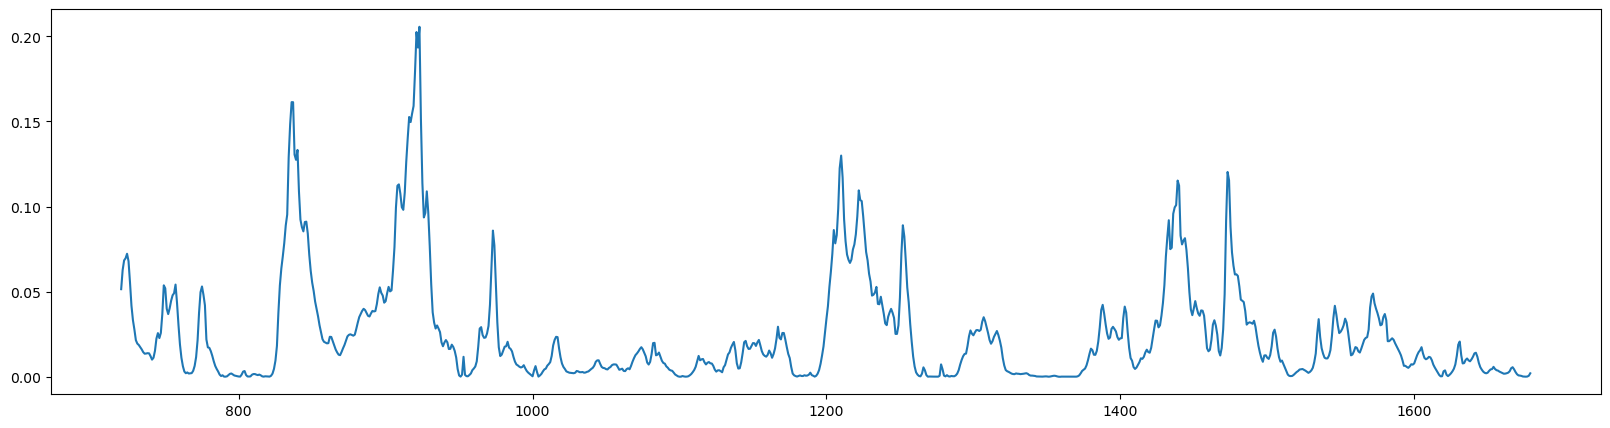

In [41]:
plt.figure(figsize=(20, 5))
plt.plot(df[normalised_column].fsr[24*30:24*70])
plt.show()

In [42]:
df2.Scaled_Windspeed

0         0.288595
1         0.292334
2         0.288785
3         0.287726
4         0.297384
            ...   
350635    0.221150
350636    0.212784
350637    0.215426
350638    0.205650
350639    0.220579
Name: Scaled_Windspeed, Length: 350640, dtype: float64

plt.figure(figsize=(20, 5))
plt.plot(df2.Scaled_Windspeed[24*30:24*70])
plt.show()

In [43]:
#we can see that fsr and Scaled_Windspeed has got a definite influence on the Power out put
df1=df2.loc[:,['fsr','Scaled_Windspeed','Power']]

In [44]:
df1

,fsr,Scaled_Windspeed,Power
0,0.034656,0.288595,0.644486
1,0.031856,0.292334,0.664754
2,0.030083,0.288785,0.645523
3,0.029148,0.287726,0.639762
4,0.031296,0.297384,0.691878
...,...,...,...
350635,0.012311,0.221150,0.300399
350636,0.009797,0.212784,0.266324
350637,0.009326,0.215426,0.276822
350638,0.007649,0.205650,0.239144


In [45]:
def plot_cols(df1):
  fig, axs = plt.subplots(3, figsize=(10, 8))
  fig.suptitle('Plotting the columns of the data')
  for i, col in enumerate(df1.columns):
    axs[i].plot(df1[col])

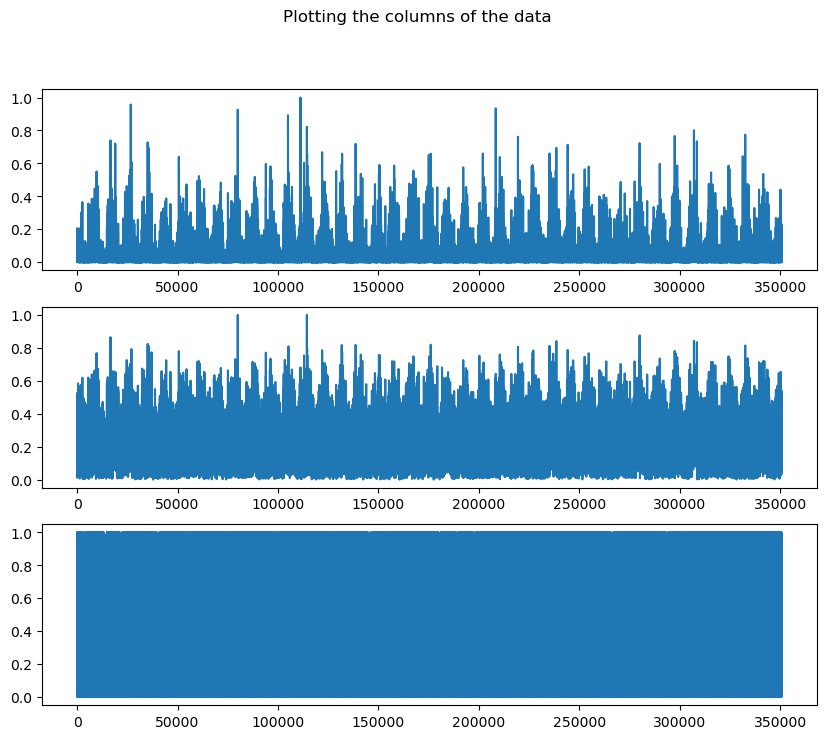

In [46]:
plot_cols(df1)

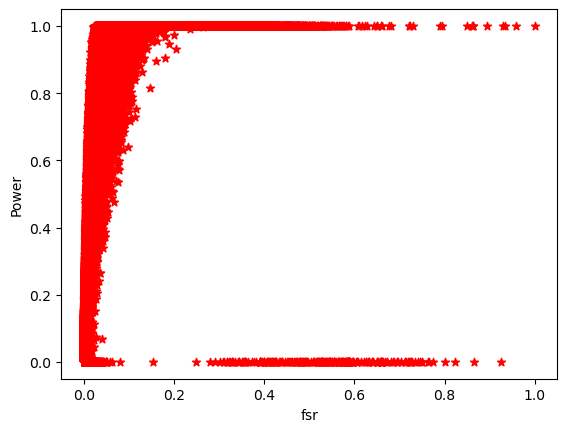

In [47]:
%matplotlib inline
plt.xlabel('fsr')
plt.ylabel('Power')
plt.scatter(df1.fsr,df1.Power,color='red',marker='*')

In [48]:
df1.describe()

,fsr,Scaled_Windspeed,Power
count,350640.000000,350640.000000,350640.000000
mean,0.036489,0.265359,0.508751
std,0.057685,0.124817,0.376326
min,0.000000,0.000000,0.000000
25%,0.003442,0.172485,0.133489
50%,0.014319,0.259517,0.485536
75%,0.043345,0.348411,0.923138
max,1.000000,1.000000,1.000000


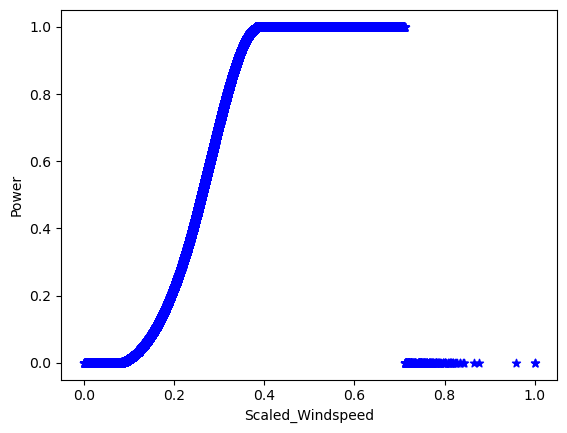

In [49]:
%matplotlib inline
plt.xlabel('Scaled_Windspeed')
plt.ylabel('Power')
plt.scatter(df1.Scaled_Windspeed,df1.Power,color='blue',marker='*')

Text(0, 0.5, 'Count')

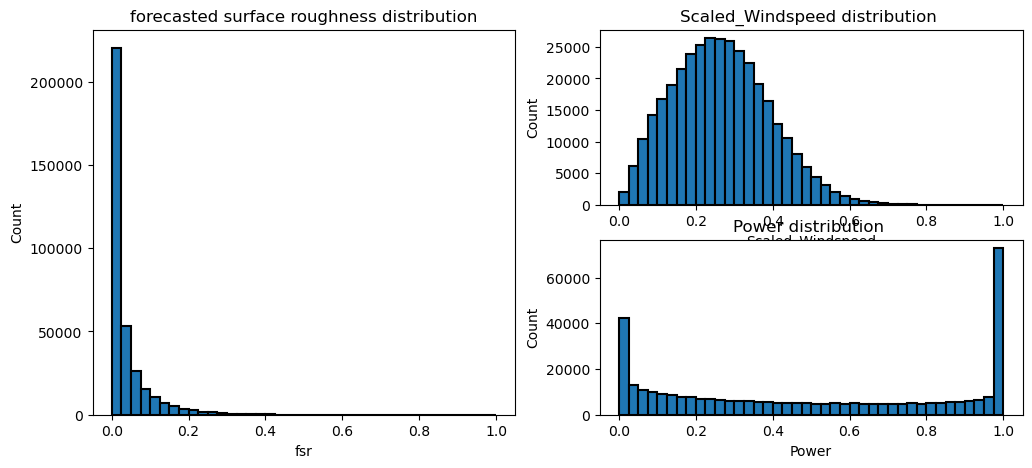

In [50]:
f = plt.figure(figsize=(12,5))

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(224)


ax1.hist(df1['fsr'],bins = 40, edgecolor = 'black', linewidth = 1.5)
ax1.set_title('forecasted surface roughness distribution')
ax1.set_xlabel('fsr')
ax1.set_ylabel('Count')
ax2.hist(df1['Scaled_Windspeed'],bins = 40, edgecolor = 'black', linewidth = 1.5)
ax2.set_title('Scaled_Windspeed distribution ')
ax2.set_xlabel('Scaled_Windspeed')
ax2.set_ylabel('Count')
ax3.hist(df1['Power'],bins = 40, edgecolor = 'black', linewidth = 1.5)
ax3.set_title('Power distribution ')
ax3.set_xlabel('Power')
ax3.set_ylabel('Count')


In [51]:
##check for stationarity by using Augmented Dickey Fuller Test

# based on: https://machinelearningmastery.com/time-series-data-stationary-python/
import statsmodels.graphics.tsaplots
import statsmodels.tsa.stattools
def augmented_df(ts):             
    result = statsmodels.tsa.stattools.adfuller(
        ts, 
        autolag='AIC')
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

augmented_df(df1['Scaled_Windspeed'].values)
augmented_df(df1['Power'].values)
augmented_df(df1['fsr'].values)


ADF Statistic: -40.814808
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF Statistic: -41.562461
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
ADF Statistic: -39.523111
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [52]:
## found that data is stationary


In [53]:
import torch
import torch.nn as nn

In [54]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [55]:
y = df1['Power'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [56]:
print(f"shape of train_set : {train_set.shape}")
print(f"shape of test_set : {test_set.shape}")

shape of train_set : (350628,)
shape of test_set : (12,)


In [57]:
train_set[:10]

array([0.64448639, 0.66475374, 0.64552265, 0.63976199, 0.69187833,
       0.72059517, 0.7777657 , 0.80048656, 0.79808133, 0.78751638])

In [58]:
train_norm=train_set

In [59]:
##@@Data preparation for LSTM training
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

In [60]:
train_norm

tensor([0.6445, 0.6648, 0.6455,  ..., 0.3660, 0.4520, 0.3839])

In [61]:
len(train_norm)

350628

In [62]:


# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq, ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 350628-12-12

350616

In [63]:
train_data[:2]

[(tensor([0.6445, 0.6648, 0.6455, 0.6398, 0.6919, 0.7206, 0.7778, 0.8005, 0.7981,
          0.7875, 0.8705, 0.7758]),
  tensor([0.7451])),
 (tensor([0.6648, 0.6455, 0.6398, 0.6919, 0.7206, 0.7778, 0.8005, 0.7981, 0.7875,
          0.8705, 0.7758, 0.7451]),
  tensor([0.7996]))]

In [64]:
#Define the model
#We will be using an LSTM layer of size (1, 1000).

class PowerPredictor(nn.Module):

    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = (torch.zeros(1, 1, self.hidden_size),
                       torch.zeros(1, 1, self.hidden_size))
    def forward(self, seq):
        out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(out.view(len(seq), -1))
        return pred[-1]


In [65]:
predictorModel = PowerPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(predictorModel.parameters(), lr=0.001)

predictorModel

PowerPredictor(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [66]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


In [67]:
X=df1[['Scaled_Windspeed','fsr']]
y=df1['Power']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
gbrt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gbrt.fit(X_train, y_train)
# Make predictions
y_pred = gbrt.predict(X_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 3.807451439930053e-06


In [71]:
y_pred

array([0.99991982, 0.99262838, 0.07435171, ..., 0.03152963, 0.8523153 ,
       0.99991982])

In [72]:
len(y_pred)

70128